# Extreme precipitation: Changes under climate scenarios worfklow [Data processing]
Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/HEAVY_RAINFALL/main?labpath=EXTREME_PRECIPITATION_preprocess.ipynb) to launch this notebook on MyBinder.<br>
Click [![Heavy Rainfall](https://img.shields.io/badge/HEAVY_RAINFALL-repository-blue)](https://github.com/CLIMAAX/HEAVY_RAINFALL/tree/main) to go to this workflow's GitHub repository.

The data used for the changes in extreme precipitation visualization has been prepared by CRAHI-UPC. The steps outlined in this page were followed to extract the necessary annual maxima precipitation, fit the different distributions, and compute the return periods for specific durations and scenarios across the European region.

To illustrate the application of these steps, we provide a **specific example for the Catalonia region in Spain**. Feel free to explore the code and modify it according to your specific research needs. 
 
Please refer to the visualisation page that accompanies this code to explore the entire European region and additional climate information.

## Prepare your workspace.
:::{admonition} Find out about the Python libraries we will use in this notebook.
:class: hint
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - A library to request data from the datasets listed in the CDS catalogue.
* [numpy](https://numpy.org/doc/stable/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data.
* [scipy](https://docs.scipy.org/doc/scipy/) - Provides algorithms for optimization, statistics and many other classes of problems.
* [matplotlib](https://matplotlib.org/stable/) -  A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - A package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
* [contextily](https://contextily.readthedocs.io/en/latest/) - To retrieve matplotlib compatible tile maps from the internet.

### Load libraries

In [1]:
# Libraries to download data and manage files
import os
import cdsapi
import zipfile

# Libraries for numerical computations, array manipulation and statistics.
import numpy as np
import xarray as xr
import scipy.stats as sst

# Libraries to handle geospatial data
import rioxarray as rio

# Libraries to plot maps, charts and tables
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import plotly.express as px
import contextily as ctx

# Choosing the matplotlib backend
%matplotlib inline

### Setting your directory
The next cell will create the *heavy_rainfall_workflow* directory in the directory where the notebook is saved.

In [ ]:
# Define the directory for the heavy workflow preprocess
workflow_dir = 'extreme_precipiation_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)



---

## Step 1: Download the EURO-CORDEX from the Climate Data Store.
For this analysis, EURO-CORDEX climate projections for _precipitation flux_ at a 12km spatial resolution have been employed. These projections are readily accessible to the public through the [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview) (CDS) portal. 
The EURO-CORDEX data can be downloaded through the CDS API. Learn how to use it [here](https://cds.climate.copernicus.eu/api-how-to).

For this example, we will guide you through downloading two different 30-year frames from the EURO-CORDEX precipitation data with a temporal resoltuion fo 3 hours. The selected timeframes are 1975-2005 (baseline or historic simulations) and 2040-2070 (climate projections). We will select a specific combination of General Circulation Model (GCM), Regional Climate model (RCM), and a Representative Concentration Pathway (RCP).

:::{note}
Feel free to explore the code and modify it according to your specific research needs (e.g., pair of models or scenarios). explore the available data for CORDEX by referring to the resources found [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form).
:::

In [ ]:
# Change the KEY to your own
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "1234"
c = cdsapi.Client(url=URL, key=KEY)

### 1975-2005 TIMEFRAME
# Define zip file's absolute path
zip_path_baseline = os.path.join(data_dir, 'cordex_pr_3h_2075_2005_historical.zip')

c.retrieve(
        'projections-cordex-domains-single-levels',
        {
            'format': 'zip',
            'domain': 'europe',
            'experiment': 'historical',
            'horizontal_resolution': '0_11_degree_x_0_11_degree',
            'temporal_resolution': '3_hours',
            'variable': 'mean_precipitation_flux',
            'gcm_model': 'ichec_ec_earth',
            'rcm_model': 'knmi_racmo22e',
            'ensemble_member': 'r1i1p1',
            'start_year': ['1976', '1977', '1978', '1979','1980', '1981', 
                    '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', 
                    '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', 
                    '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005'],
            'end_year': ['1977', '1978', '1979','1980', '1981', 
                    '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', 
                    '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', 
                    '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006'],
        },
        zip_path_baseline)

In [ ]:
### 2040-1070 TIMEFRAME
# Define zip file's absolute path
zip_path_projection = os.path.join(data_dir, 'cordex_pr_3h_2041_2070_rcp85.zip')

c.retrieve(
        'projections-cordex-domains-single-levels',
        {
            'format': 'zip',
            'domain': 'europe',
            'experiment': 'rcp_8_5',
            'horizontal_resolution': '0_11_degree_x_0_11_degree',
            'temporal_resolution': '3_hours',
            'variable': 'mean_precipitation_flux',
            'gcm_model': 'ichec_ec_earth',
            'rcm_model': 'knmi_racmo22e',
            'ensemble_member': 'r1i1p1',
            'start_year': ['2041', '2042', '2043', '2044', '2045', '2046',
                           '2047', '2048', '2049', '2050', '2051', '2052',
                           '2053', '2054', '2055', '2056', '2057', '2058',
                           '2059', '2060', '2061', '2062', '2063', '2064',
                           '2065', '2066', '2067', '2068', '2069', '2070'],
            'end_year': ['2042', '2043', '2044', '2045', '2046',
                           '2047', '2048', '2049', '2050', '2051', '2052',
                           '2053', '2054', '2055', '2056', '2057', '2058',
                           '2059', '2060', '2061', '2062', '2063', '2064',
                           '2065', '2066', '2067', '2068', '2069', '2070', '2071'],
        },
        zip_path_projection)

Extract the downloaded files to your data directory.

In [ ]:
with zipfile.ZipFile(zip_path_baseline, 'r') as zObject:
    zObject.extractall(path=data_dir)

with zipfile.ZipFile(zip_path_projection, 'r') as zObject:
    zObject.extractall(path=data_dir)


---

## Step 2: Explore the data.
The downloaded files from CDS have a filename structure that describes the exact dataset contained. The general structure is the following:

<p style="text-align: center;">variable_domain_gcm_rcp_ensemble_rcm_version_temporal resolution_ start day_end day</p>

Load one of the files and explore the content and structure of the dataset. Notice the dimensions, coordinates,  data variables, indexes and attributes as well as the description of the spatial reference system in _rotated_pole()_.

In [4]:
# Define the absolute path for a specific file
filename_precipitation_example = os.path.join(data_dir,
                       'pr_EUR-11_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1_3hr_2041010100-2042010100.nc')

# Open the netCDF file as a dataset using xarray
dataset_precipitation_example = xr.open_dataset(filename_precipitation_example, decode_coords = 'all')

# Display said dataset
dataset_precipitation_example

<xarray.Dataset>
Dimensions:       (rlon: 424, rlat: 412, time: 2920, bnds: 2)
Coordinates:
    rotated_pole  |S1 ...
  * rlon          (rlon) float64 -28.38 -28.27 -28.16 ... 17.93 18.05 18.16
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lat           (rlat, rlon) float64 ...
  * time          (time) datetime64[ns] 2041-01-01T01:30:00 ... 2041-12-31T22...
    time_bnds     (time, bnds) datetime64[ns] ...
Dimensions without coordinates: bnds
Data variables:
    pr            (time, rlat, rlon) float32 ...
Attributes: (12/25)
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     RCP8.5 run
    experiment_id:                  rcp85
    realization:                    1
    driving_experiment:             ICHEC-EC-EARTH,rcp85,r1i1p1
    ...                             ...
    knmi_model_comment:             RACMO22E: baseline physics from ECMWF CY3...
    knmi_version_comment:           v1: reference version for Europe and othe...
    knmi_grib_path:                 mos.knmi.nl:/climreg/CXEUR12/eCS6-v441-fE...
    creation_date:                  2015-12-10T17:13:36Z
    c3s_disclaimer:                 ""
    tracking_id:                    hdl:21.14103/157ee1ba-f9ba-4f87-82f2-206f...


---

## Step 3: Extract the temporal series of annual maximum precipitation.
For this example, the annual maximum precipitation for 3h, 6h, 12h durations (derived from the 3-hour temporal step), have been extracted in a new netCDF (network Common Data Form) for the Catalonia region.
Some important functions from the ```xarray``` library will be used used:
* ```sel``` to select certain indexes of the dataset/dataarray by value.
* ```open_mfdataset``` to open netCDF files.
* ```rolling``` to roll over a dataarray within a specific dimension to apply an operation.
* ```to_netcdf``` to save dataset/dataaray as netcdf.
* ```resample``` to group by year for performing an operation.

In addition, the ```rioxarray``` library is used to properly write the coordinate reference system (CRS) so that the new files can be well visualized with a GIS application.

Use the code below to generate the new netCDF containing the maximum precipitation for the specified durations in the Catalonia region. To define another region, have a look at the function ```cut_to_region``` and modify it accordingly.

:::{warning}
This could take some time due to the large dataset the script is handling.
:::

In [25]:
# Auxiliary function to slice each dataset to a particular region (CATALONIA) with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(-8.8,-6), rlon = slice(-13.8,-10.8))
    return ds

In [ ]:
### BASELINE   
# Open the 30 files as a single dataset using a preprocess function.
ds_prec_baseline = xr.open_mfdataset(f'{data_dir}/pr_EUR-11*historical*.nc', decode_coords='all',
                                     preprocess=cut_to_region)
# Define the CRS
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Write the CRS into the dataset
ds_prec_baseline.rio.write_crs(rotated_pole, inplace=True)
# Units of pr variable are kg m-2 s-1. Need to convert to mm.
da_prec_baseline = ds_prec_baseline['pr']*3600*3
# Assign the new units to the variable
da_prec_baseline.attrs['units'] = 'mm'

### CLIMATE PROJECTION (same steps as BASELINE)
ds_prec_proj = xr.open_mfdataset(f'{data_dir}/pr_EUR-11*rcp85*.nc', decode_coords='all',
                                 preprocess=cut_to_region)
ds_prec_proj.rio.write_crs(rotated_pole, inplace=True)
da_prec_proj = ds_prec_proj['pr']*3600*3
da_prec_proj.attrs['units'] = 'mm'

In [5]:
# For every duration (3h, 6h, 12h), compute the annual maximum and save as a new netCDF file.
for duration in [3, 6, 12]:
    # longitude of window to roll the DataSet
    window = int(duration/3)

    ### BASELINE 
    # Create new DataArray with annual maxima
    da_prec_baseline_aux = da_prec_baseline.rolling(time=window).sum().resample(time = 'YS').max(keep_attrs=True)
    # Assign new 'duration' dimension to save this information and rename variable
    da_prec_baseline_aux = da_prec_baseline_aux.expand_dims(dim = {'duration': [duration]}, axis = 0).rename('pr_max')
    # Define name of new netCDF file
    filename_baseline_aux = f'pr_annualMax_{duration}h_1975-2005.nc'
    # Save to your results' directory as a netCDF
    da_prec_baseline_aux.to_netcdf(os.path.join(data_dir, filename_baseline_aux))

    ### CLIMATE PROJECTION (same steps as BASELINE)
    da_prec_proj_aux = da_prec_proj.rolling(time=window).sum().resample(time = 'YS').max(keep_attrs=True)
    da_prec_proj_aux = da_prec_proj_aux.expand_dims(dim = {'duration': [duration]}, axis = 0).rename('pr_max')
    filename_proj_aux = f'pr_annualMax_{duration}h_2040-2070.nc'
    da_prec_proj_aux.to_netcdf(os.path.join(data_dir, filename_proj_aux))


Let us have a look to one of the new netCDF created. Notice the new dimension ```duration``` and that now there is only 30 values for the dimension ```time```.

In [32]:
# Open netCDF with xarray (now we just have one file for each duration)
ds_pr_max_example = xr.open_dataset(os.path.join(data_dir, 'pr_annualMax_3h_2040-2070.nc'),
                                  decode_coords='all')

# Display the dataset
ds_pr_max_example

<xarray.Dataset>
Dimensions:       (duration: 1, rlon: 18, rlat: 18, time: 30)
Coordinates:
  * duration      (duration) int64 3
  * rlon          (rlon) float64 -12.97 -12.87 -12.76 ... -11.32 -11.21 -11.11
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 -8.965 -8.855 -8.745 ... -7.315 -7.205 -7.095
    lat           (rlat, rlon) float64 ...
    rotated_pole  int64 ...
  * time          (time) datetime64[ns] 2041-01-01 2042-01-01 ... 2070-01-01
Data variables:
    pr_max        (duration, time, rlat, rlon) float32 ...

:::{note}
If a pair of rotated latitude and longitude coordinates is selected, it is possible to plot (with the ```plotly``` library) the evolution of the annual maximum precipitation series of a given pixel. Use the code below to explore the different series across Catalonia or your region by changing the latitude and longitude inputs.
:::

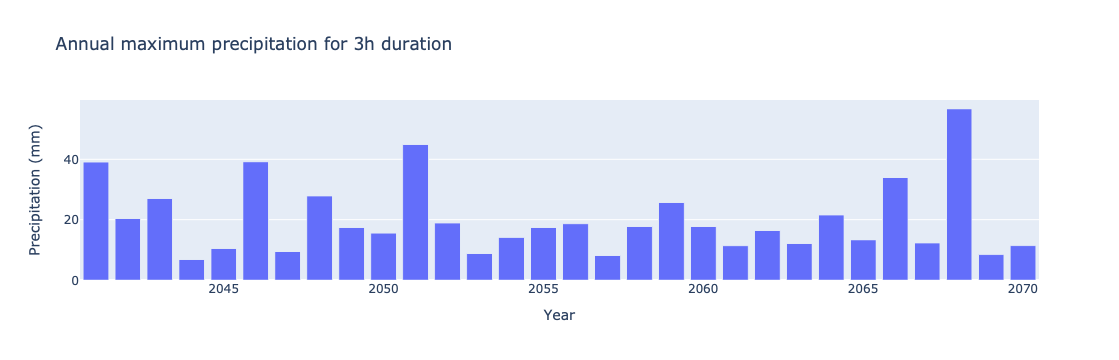

In [33]:
# Define specific spatial coordinates within your selected region and one of the available durations
lat = -11
lon = -8
dur = 3
# Selecting a duration and one specific point.
da_pr_max_example = ds_pr_max_example['pr_max'].sel(duration=dur, rlat = lat, rlon = lon, method = 'nearest')
ds_pr_max_example.close
# Converting dataarray to dataframe for plotly library to understand.
df_pr_max_example = da_pr_max_example.to_dataframe().reset_index()
# Define bar chart and customize it.
figure = px.bar(df_pr_max_example, x="time", y="pr_max", title=f'Annual maximum precipitation for {dur}h duration')
figure.update_layout(yaxis=dict(title="Precipitation (mm)"),
                     xaxis = dict(title="Year")) #, range=[10, max(df.precipitation)+5]))
figure.show()


---

## Step 4: Define the function for fitting a probability distribution to the annual maximum precipitation series.
A probability distribution is a function representing the probability of occurrence of a random variable. By fitting a distribution to a set of hydrologic data (e.g., annual maximum precipitation data), the probabilistic information of the sample data can be compactly summarized in the function and its associated parameters. Distributions of extreme values, such as the annual maximum precipitation, have been shown by Fisher and Tippet (1928) and Jenkinson (1955) to converge to one of the three special cases of a single distribution called General Extreme Value (GEV) distribution.

The following code defines the function that explores which one of the three special cases of the single GEV distribution best represents each pixel’s annual maximum precipitation series.  Feel free to modify the code to employ another probabilistic distribution function based on your region’s technical studies. However, keep in mind that in such cases a Goodness of Fit test (e.g., Kolmogorov-Smirnov) must be performed.

To read more about the GEV other commonly used probabilistic distributions for hydrologic data and goodness of fit test refer to Applied Hydrology (Chow, 1988).

In [9]:
# Function defined to fit a 1D (for one pixel) temporal series.
from scipy.stats import gumbel_r, genextreme, lognorm, pearson3, ks_1samp

def distribution_fit(ts_max):
    # Parameters for the GEV fitting.
    param = genextreme.fit(ts_max)
    # Kolmogorov-Smirnov test.
    ks = ks_1samp(ts_max, genextreme.cdf, param)

    ### Uncomment the next lines to visualize the fitting.
    # x = np.linspace(0, np.max(ts_max), 100)
    # fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    # res = sst.probplot(ts_max, dist=genextreme, sparams=param, plot=ax[0])
    # ax[1].plot(x, genextreme.cdf(x, *param))
    # ax[1].hist(ts_max, density=True, cumulative = True)
    # ax[2].plot(x, genxetreme.pdf(x, *param))
    # ax[2].hist(ts_max, density=True)
    
    # plt.suptitle(f'Plot for genextreme distribution')

    return genextreme, param


The code below exemplifies this function over the annual maximum series extracted from the latitude and longitude coordinates selected in the example at the end of step 3.

In [13]:
annual_maxima_point = da_pr_max_example.values
distribution_selected, parameters_selected = distribution_fit(annual_maxima_point)
print(f'The parameters for {distribution_selected.name} are {parameters_selected}')

The parameters for genextreme are (-0.3571578505385625, 13.695890597844421, 6.34188632094574)



---

## Step 5. Expected intensities for different return periods.
After one of the three special cases of the GEV distribution is selected, the last step is to compute the expected rainfall for each duration (Remember: 3, 6 and 12 hours) and defined return periods (2, 5, 10, 25, 50, 100, 200 and 500). Feel free to modify these values based on your research needs.

More information regarding the equations employed to calculate return values and their confidence intervals can be found in Applied Hydrology (Chow, 1988).

In [22]:
# Code for computing the intensity values and confidence intervals.

def compute_intensity(ts_max, dist_fit, param_fit):
    # Select distribution (Needed for applying functions to whole region afterwards)
    if not dist_fit:
        dist_fit, param_fit = distribution_fit(ts_max)
    # Define return years/frequency
    frequencies = np.asarray([2,5,10,25,50,100,200,500])
    n = ts_max.size
    data_log = np.log(ts_max)
    # Values and confidence intervals are defined using a frequency factor that varies with each distribution.
    # GEV distribution are differentiated by the shape parameter.
    if param_fit[0] == 0: # GUMBEL GEV I
        data = ts_max
    elif param_fit[0] != 0: # GEV II and III
        data = data_log
    else:
        raise Exception("Distribution selected has to be: gumbel_r or genextreme")
        
    # Level of confidence at 95%
    normal_level = np.power(1.96, 2)
    a = 1 - normal_level / 2 / (n - 1)
    freq_factor = -np.sqrt(6) / np.pi * (0.5772 + np.log(np.log(frequencies / (frequencies - 1))))
    b = np.power(freq_factor, 2) - normal_level / n

    data_mean = data.mean()
    data_std = data.std()
    freq_factor_upper = freq_factor + np.sqrt(np.power(freq_factor, 2) - a * b)  # falta divide by a
    freq_factor_lower = freq_factor - np.sqrt(np.power(freq_factor, 2) - a * b)
    
    # return value, ci_lower, ci_upper
    return_value = data_mean + freq_factor * data_std
    ci = [return_value, data_mean + data_std * freq_factor_lower / a,
          data_mean + data_std * freq_factor_upper / a]

    if param_fit[0] != 0:
        ci = np.exp(ci)

    ## Code to plot the confidence intervals.
    # plt.plot(frequencies, ci[0], frequencies, ci[1], frequencies, ci[2])
    # plt.xlabel('Return period (years)')
    # plt.ylabel('Expected intensity per duration (mm)')
    # plt.title('Values and condifence interval for expected intensities')
    # plt.show()
    
    return np.asarray(ci)

The code below exemplifies this function over the annual maximum series extracted from the latitude and longitude coordinates selected in the example at the end of step 3.

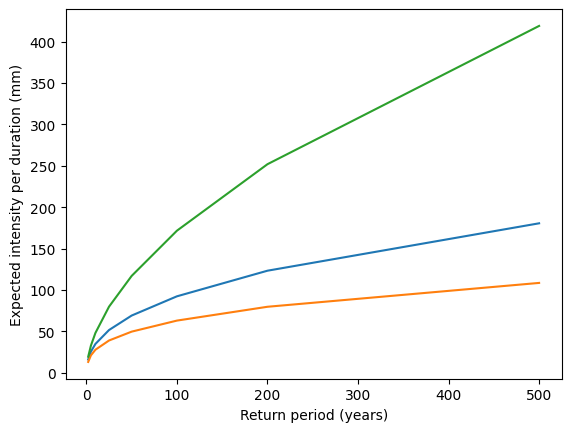

In [21]:
# Uncomment prints and plots in previous cell's to see some output for the next line
compute_intensity(da_pr_max_example.values, distribution_selected, parameters_selected);


---

## Step 6: Apply step 4 and 5 to an entire region.
After defining the functions for fitting a probabilistic distribution and calculating the expected rainfall intensities for different return periods we are ready to apply them to an entire region.

To do this, the function ```apply_along_axis``` will be used to easily apply steps 4 and 5 to each pixel of the defined region, in this case Catalonia (Go to step 3 for more information).

:::{note}
Uncomment previous lines of code reserved to plot graphs and print information to have a cleaner outcome.
:::

In [ ]:
### BASELINE
# Select a duration.
dur = 3
# Open the corresponding .nc file for the baseline.
ds_pr_max_baseline = xr.open_dataset(os.path.join(data_dir, f'pr_annualMax_{dur}h_1975-2005.nc'),
                                 decode_coords='all')

# Values of variables pr_max as a numpy ndarray.
data_baseline = ds_pr_max_baseline['pr_max'].values

# Apply compute_intensity function to every pixel. Return a new ndarray.
idf_values_baseline = np.apply_along_axis(compute_intensity, 1, data_baseline, dist_fit = '', param_fit='')

# Create a new Dataset with the intensities. Some coordinates are the same as in the original file (lat, lon, duration).
ds_idf_baseline = xr.Dataset(
            data_vars = {'idf' : (['duration', 'ci', 'frequency', 'rlat', 'rlon'], idf_values_baseline)},
            coords = {'duration': ds_pr_max_baseline.indexes['duration'],
                      'ci': ['value', 'lower', 'upper'],
                      'frequency': np.asarray([2,5,10,25,50,100,200,500]),
                      'rlat': ds_pr_max_baseline.indexes['rlat'],
                      'rlon': ds_pr_max_baseline.indexes['rlon']
                      }
            )
# Define the CRS
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Write CRS 
ds_idf_baseline.rio.write_crs(rotated_pole, inplace=True)

# Save as a netCDF file in the results directory.
ds_idf_baseline.to_netcdf(os.path.join(results_dir, f'idf_{dur}h_1975-2005.nc'))
ds_idf_baseline.close()

In [ ]:
### CLIMATE PROJECTION (same steps as BASELINE)
dur = 3
ds_pr_max_proj = xr.open_dataset(os.path.join(data_dir, f'pr_annualMax_{dur}h_2040-2070.nc'),
                                 decode_coords='all')

data_proj = ds_pr_max_proj['pr_max'].values

idf_values_proj = np.apply_along_axis(compute_intensity, 1, data_proj, dist_fit = '', param_fit='')

ds_idf_proj = xr.Dataset(
            data_vars = {'idf' : (['duration', 'ci', 'frequency', 'rlat', 'rlon'], idf_values_proj)},
            coords = {'duration': ds_pr_max_proj.indexes['duration'],
                        'ci': ['value', 'lower', 'upper'],
                        'frequency': np.asarray([2,5,10,25,50,100,200,500]),
                        'rlat': ds_pr_max_proj.indexes['rlat'],
                        'rlon': ds_pr_max_proj.indexes['rlon']
                        }
            )

rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
ds_idf_proj.rio.write_crs(rotated_pole, inplace=True)

ds_idf_proj.to_netcdf(os.path.join(results_dir, f'idf_{dur}h_2040-2070.nc'))
ds_idf_proj.close()

The new netCDFs can be found in the results directory defined in the _Prepare your workspace_ section. Each file contains the expected rainfall precipitation for a specific duration (e.g, 3 hours), RCP (e.g., 8.5) and model pair (e.g., ICHEC-EC-EARTH).


---

## Step 7: Extract precipitation changes (%) relative to a defined year period.
Now that we have computed the expected precipitation for two different 30-year periods (see Step 1), we can compare their results. This exercise can help us to identify if there is a positive or negative precipitation change in the region relative to a climate baseline simulation.
 
In this example, we will compute the change of the rainfall (%) for 2040-2070 relative to the 1975-2005 period in Catalonia. Feel free to modify the code and analysis based on your research needs.

In [3]:
# Open the netCDF files for two different 30-year period expected precipitation for a specific duration (3, 6 or 12)
dur = 3

# Baseline intensity file
ds_expected_prec_baseline = xr.open_dataset(os.path.join(results_dir, f'idf_{dur}h_1975-2005.nc'))
# Select values
ds_expected_prec_baseline = ds_expected_prec_baseline.idf.sel(ci ='value', duration = dur)

# Projection intensity file
ds_expected_prec_proj = xr.open_dataset(os.path.join(results_dir, f'idf_{dur}h_2040-2070.nc'))
# Select values
ds_expected_prec_proj = ds_expected_prec_proj.idf.sel(ci = 'value', duration = dur)

# Compute change (%) as a new DataArray
ds_expected_prec_change = (ds_expected_prec_proj - 
                                    ds_expected_prec_baseline)/ds_expected_prec_baseline*100
# Add duration as dimension and rename variable
ds_expected_prec_change = ds_expected_prec_change.expand_dims(
                            dim = {'duration': [dur]}, axis = 0).rename('idf_change')
# Save as a netCDF in results directory
ds_expected_prec_change.to_netcdf(os.path.join(results_dir, f'idf_{dur}h_baseline_2040-2070_change.nc'))


---

## Step 8: Plot the results.
Let's visualise the results! For this, we will use the ```matplotlib```,  ```cartopy``` and ```contextily``` libraries.

In [10]:
### MAP GLOBAL CHARACTERISTICS
# Define the projection and the projection as string
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
crs_string = crs.to_string()

# Colormap definition for expected intensity values
z_pal = [0., 10., 20, 25, 30, 35, 40, 45, 50, 60., 70., 80, 90., 100., 110, 120., 130, 140]
pal_rgb = ['#ffffff00', '#d6e2ffff', '#8db2ffff', '#626ff7ff', '#0062ffff', '#019696ff', '#01c634ff',
           '#63ff01ff', '#c6ff34ff', '#ffff02ff', '#ffc601ff', '#ffa001ff', '#ff7c00ff', '#ff1901ff', '#a20a28ff',
           '#9b159dff', '#d294d3ff', '#f6e9f6ff']
cmap, norm = from_levels_and_colors(z_pal, pal_rgb, extend='max')

# Colormap definition for relative change
cmap_rel = mpl.cm.RdYlGn
relative_bounds = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
norm_rel = mpl.colors.BoundaryNorm(relative_bounds, cmap_rel.N, extend='both')

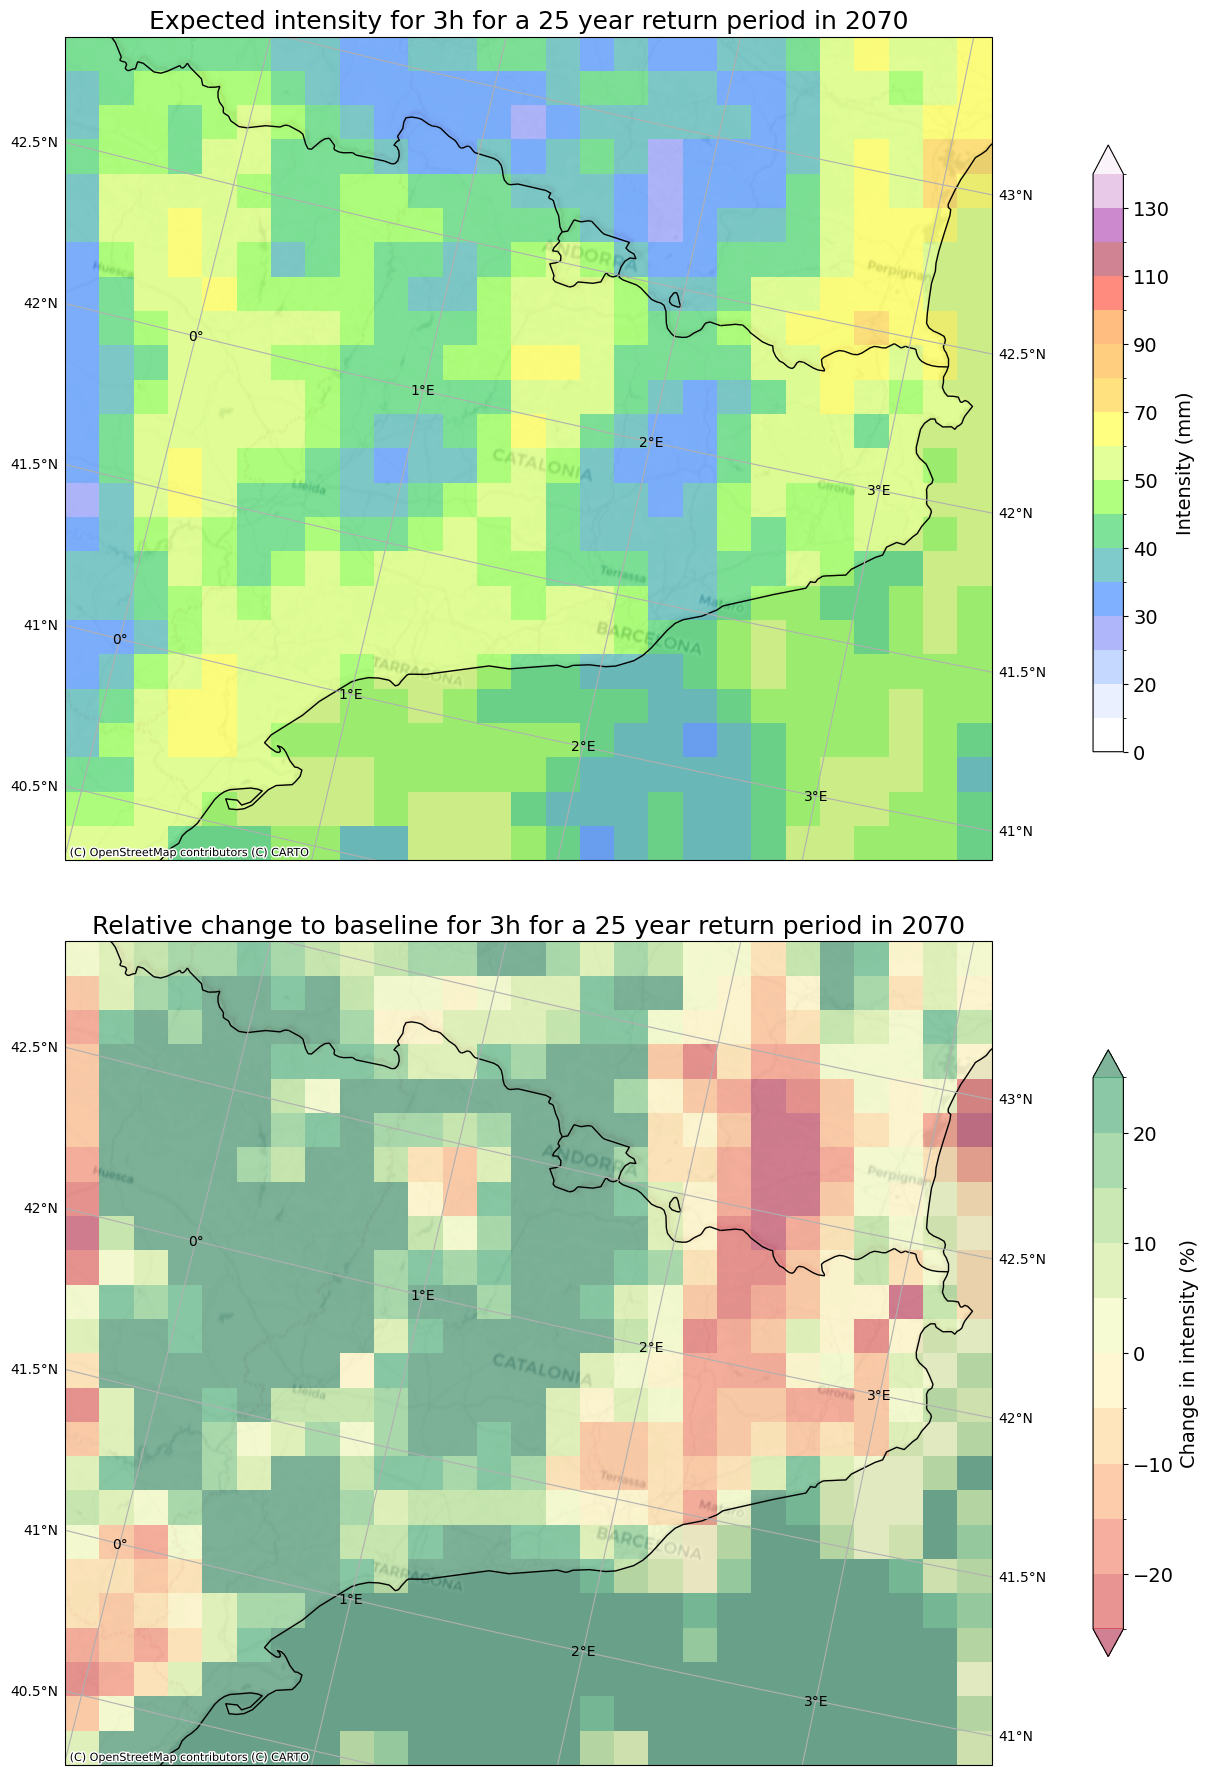

In [11]:
# Select duration and open the correponding .nc file of intensities and relative change.
dur = 3

ds = xr.open_dataset(os.path.join(results_dir, f'idf_{dur}h_2040-2070.nc'), decode_coords='all')
ds_change = xr.open_dataset(os.path.join(results_dir, f'idf_{dur}h_baseline_2040-2070_change.nc'),
                            decode_coords='all')

# Select which return period to plot from [2,5,10,25,50,100,200,500]
freq = 25

# Create map with matplotlib and cartopy
fig, ax = plt.subplots(2, 1, figsize = (12,18), layout="constrained",subplot_kw={'projection': crs})

# EXPECTED INTENSITIES PLOT
data = ds.idf.sel(duration = dur, ci = 'value').sel(frequency = freq)
im=ax[0].pcolormesh(ds['rlon'], ds['rlat'], data, norm = norm ,cmap = cmap, alpha = 0.5)
ax[0].set_title(f'Expected intensity for {dur}h for a {freq} year return period in 2070', fontsize = 18)

# Adding gridlines and features to the map
gridlines = ax[0].gridlines(draw_labels=True)
ax[0].add_feature(cfeature.COASTLINE)
ax[0].add_feature(cfeature.BORDERS)
ctx.add_basemap(ax=ax[0], crs=crs_string, source=ctx.providers.CartoDB.Positron)

fig.canvas.header_visible = False
cbar = fig.colorbar(im, ax=ax[0], orientation='vertical',shrink = 0.7)
cbar.set_label('Intensity (mm)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)

# RELATIVE CHANGE PLOT
data_change = ds_change.idf_change.sel(duration = dur, frequency = freq)
im_change=ax[1].pcolormesh(ds_change['rlon'], ds_change['rlat'], data_change, norm = norm_rel ,cmap = cmap_rel,
                    alpha = 0.5)
gridlines = ax[1].gridlines(draw_labels=True)
ax[1].add_feature(cfeature.COASTLINE)
ax[1].add_feature(cfeature.BORDERS)
ctx.add_basemap(ax=ax[1], crs=crs_string, source=ctx.providers.CartoDB.Positron)


ax[1].set_title(f'Relative change to baseline for {dur}h for a {freq} year return period in 2070', fontsize = 18)
cbar_rel = fig.colorbar(im_change, ax=ax[1], orientation='vertical',shrink = 0.7)  
cbar_rel.set_label('Change in intensity (%)', fontsize = 14)
cbar_rel.ax.tick_params(labelsize=14)

We encourage you to adapt the code for your local area and explore how specific critical impact rainfall thresholds will evolve under climate change scenarios (see section on critical thresholds within the heavy rainfall space for more information). To facilitate the analysis and identify your critical areas or points of interest, we recommend overlaying your relevant local vulnerability (e.g., age groups, land use) and exposure (e.g, population, critical infrastructure) datasets with the calculated rainfall.

---
## Authors
The Center of Applied Research in Hydrometrology from the Universitat Politècnica de Catalunya (CRAHI-UPC). The members involved in the development of this workflow were the following (alphabetic order):
 
Marta Gabarró Solanas<br>
Víctor González<br>
Erika R. Meléndez-Landaverde<br>
Daniel Sempere-Torres

--- 

## References
Chow, V.T., Maidment, D.R. and Mays, L.W. (1988) Applied Hydrology. International Edition, McGraw-Hill Book Company, New York.

Fisher, R. A., & Tippett, L. H. (1928). Limiting forms of the frequency distribution of the largest or smallest member of a sample. _Mathematical Proceedings of the Cambridge Philosophical Society_, 24(2), 180–190. https://doi.org/10.1017/s0305004100015681

Jenkinson, A. F. (1955). The frequency distribution of the annual maximum (or minimum) values of meteorological elements. _Quarterly Journal of the Royal Meteorological Society_, 81(348), 158–171. https://doi.org/10.1002/qj.49708134804
